# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import time
import utils
import shutil

In [5]:
"""datadir = "/Users/ijise/Desktop/cs445/project2/"
utilfn = datadir + "utils.py"
samplesfn = datadir + "samples"
shutil.copy(utilfn, ".")
shutil.copytree(samplesfn, "./samples")"""

'datadir = "/Users/ijise/Desktop/cs445/project2/"\nutilfn = datadir + "utils.py"\nsamplesfn = datadir + "samples"\nshutil.copy(utilfn, ".")\nshutil.copytree(samplesfn, "./samples")'

In [6]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [7]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    out = np.zeros((out_size, out_size, sample.shape[2]), dtype=np.uint8)
    y, x = sample.shape[:2]

    for i in range(0, out_size, patch_size):
        for j in range(0, out_size, patch_size):
            max_x = x - patch_size
            max_y = y - patch_size
            rand_x = np.random.randint(0, max_x + 1)
            rand_y = np.random.randint(0, max_y + 1)
            patch = sample[rand_y:rand_y+patch_size, rand_x:rand_x+patch_size]
            out[i:i+patch_size, j:j+patch_size] = patch[:min(patch_size, out_size-i), :min(patch_size, out_size-j)]

    return out
    



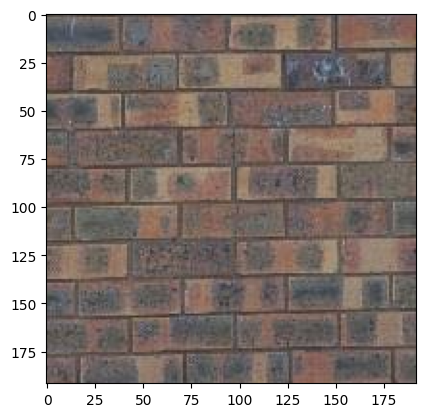

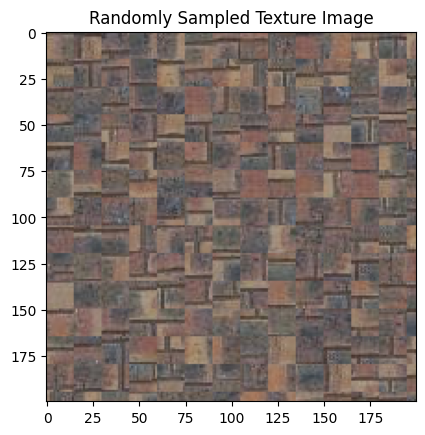

In [8]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)
    plt.title("Randomly Sampled Texture Image")
    plt.show()

### Part II: Overlapping Patches (30 pts)

In [9]:
# helper ssd_patch
def ssd_patch(temp, mask, image):
    """
    Calcs the ssd of the masked template and the image.
    
    :param template: numpy.ndarray  The template patch to match.
    :param mask: numpy.ndarray      The mask for the overlapping region.
    :param image: numpy.ndarray     The sample image from which patches are drawn.
    :return: numpy.ndarray          The SSD cost for each pixel in the image.
    """

    ssd = np.zeros_like(image[:, :, 0], dtype=np.float64)

    for i in range(3):
        masked_template = mask[:, :, i] * temp[:, :, i]
        ssd += (
            cv2.filter2D(image[:, :, i] ** 2, ddepth=-1, kernel=mask[:, :, i]) - 
            2 * cv2.filter2D(image[:, :, i], ddepth=-1, kernel=masked_template) + 
            (masked_template ** 2).sum()
        )

    return ssd

In [10]:
# helper choose_sample
def choose_sample(cost, tol):
    """
    Chooses random patch from top tol lowest-cost 
    
    :param cost: numpy.ndarray  SSD value for pixel
    :param tol: int             Tolerance for randomness 
    :return: tuple              (x, y) coordinates 
    """

    sort = np.argsort(cost.flatten())
    top = sort[:tol]
    idx = np.random.choice(top)
    y,x = np.unravel_index(idx, cost.shape)
  
    return (y,x)

In [11]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray  image
    :param out_size: int          width of output 
    :param patch_size: int        size of patches
    :param overlap: int           pixels overlapping
    :param tol: float             tolerance for randomness
    :return: numpy.ndarray        output image
    """

    # top-left corner
    out = np.zeros((out_size, out_size, sample.shape[2]), dtype=np.uint8)
    samp_y, samp_x = sample.shape[:2]
    rand_x = np.random.randint(0, samp_x - patch_size + 1)
    rand_y = np.random.randint(0, samp_y - patch_size + 1)
    first = sample[rand_y:rand_y + patch_size, rand_x:rand_x + patch_size]
    out[0:patch_size, 0:patch_size] = first

    #fill patches
    for i in range(0, out_size - patch_size + 1, patch_size - overlap):
        for j in range(0, out_size - patch_size + 1, patch_size - overlap):
            # first patch
            if i == 0 and j == 0:
                continue  
        
            # overlapping
            if i == 0:
                # left patch 
                temp = out[i:i + patch_size, j - overlap:j]
                mask = np.zeros_like(temp)
                mask[:, :overlap] = 1
            elif j == 0:
                # top patch
                temp = out[i - overlap:i, j:j + patch_size]
                mask = np.zeros_like(temp)
                mask[:overlap, :] = 1
            else:
                # top and left 
                temp = np.zeros((patch_size, patch_size, sample.shape[2]), dtype=np.uint8)
                temp[:overlap, :] = out[i - overlap:i, j:j + patch_size]  
                temp[:, :overlap] = out[i:i + patch_size, j - overlap:j]  
                mask = np.zeros((patch_size, patch_size, sample.shape[2]), dtype=np.uint8)
                mask[:overlap, :] = 1
                mask[:, :overlap] = 1
 
            #helpers
            ssd = ssd_patch(temp, mask, sample)
            patch_x, patch_y = choose_sample(ssd, tol)

            #bounds verify
            patch_y = min(patch_size, samp_y - patch_size)
            patch_x = min(patch_size, samp_x - patch_size)
            patch = sample[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]

            #copy to result
            out[i:i + patch_size, j:j + patch_size] = patch

    return out
    


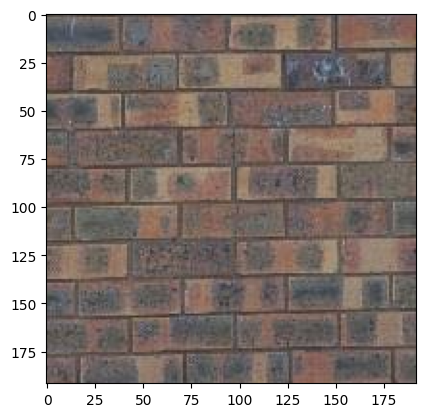

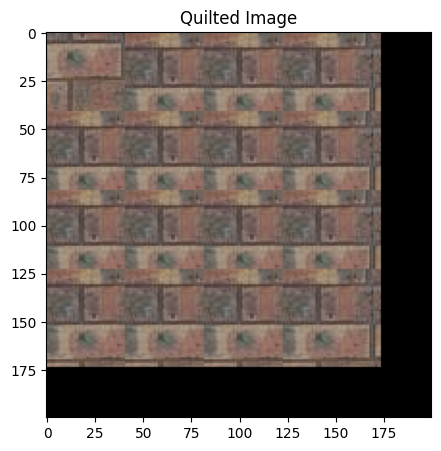

In [12]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 51
overlap = 10
tol = 4
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(5,5))
    plt.imshow(res)
    plt.title("Quilted Image")
    plt.show()

### Part III: Seam Finding (20 pts)


In [31]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    return bndcost < bndcost.mean()

In [32]:
# illustrate helpers
def illustrate(region1, region2, ssd, mask, title=""):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(region1)
    plt.title("Region 1")
    plt.subplot(1, 4, 2)
    plt.imshow(region2)
    plt.title("Region 2")
    plt.subplot(1, 4, 3)
    plt.imshow(ssd, cmap='hot')
    plt.title("SSD Cost")
    plt.subplot(1, 4, 4)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.suptitle(title)
    plt.show()

def illustrate_comb(region1, region2, temp, b_left, b_top, m_left, m_top, combined_mask, title=""):
    plt.figure(figsize=(15, 6))
    plt.subplot(2, 4, 1)
    plt.imshow(region1)
    plt.title("Left Region")
    plt.subplot(2, 4, 2)
    plt.imshow(region2)
    plt.title("Top Region")
    plt.subplot(2, 4, 3)
    plt.imshow(temp)
    plt.title("New Patch")
    plt.subplot(2, 4, 4)
    plt.imshow(combined_mask, cmap='gray')
    plt.title("Combined Mask")
    plt.subplot(2, 4, 5)
    plt.imshow(b_left, cmap='hot')
    plt.title("Left Boundary Cost")
    plt.subplot(2, 4, 6)
    plt.imshow(m_left, cmap='gray')
    plt.title("Left Mask")
    plt.subplot(2, 4, 7)
    plt.imshow(b_top, cmap='hot')
    plt.title("Top Boundary Cost")
    plt.subplot(2, 4, 8)
    plt.imshow(m_top, cmap='gray')
    plt.title("Top Mask")
    plt.suptitle(title)
    plt.show()


In [33]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray image
    :param out_size: int         x,y output
    :param patch_size: int       patch size   
    :param overlap: int          # of overlap 
    :param tol: float            tolerance
    :return: numpy.ndarray       output 
    """
    if sample.max() > 1:
        sample = sample / 255.0 
        
    out = np.zeros((out_size, out_size, sample.shape[2]), dtype=np.float64)

    samp_y, samp_x = sample.shape[:2]
    rand_x = np.random.randint(0, samp_x - patch_size + 1)
    rand_y = np.random.randint(0, samp_y - patch_size + 1)
    first = sample[rand_y:rand_y + patch_size, rand_x:rand_x + patch_size]
    out[0:patch_size, 0:patch_size] = first

    #fill patches
    for i in range(0, out_size - patch_size + 1, patch_size - overlap):
        for j in range(0, out_size - patch_size + 1, patch_size - overlap):
            if i == 0 and j == 0:
                continue
            # match image
            if i == 0:
                # left 
                left = out[i:i + patch_size, j - overlap:j]
                patch_y, patch_x = choose_sample(ssd_patch(left, np.ones_like(left), sample), tol)

                new_y = min(patch_size, samp_y - patch_y)
                temp = sample[patch_y:patch_y + new_y, patch_x:patch_x + patch_size]
                new_lap = min(overlap, temp.shape[1])

                #boundary cost
                bndcost = np.zeros((new_y, new_lap))
                for y in range(new_y):
                    for x in range(new_lap):
                        bndcost[y, x] = np.sum((left[y, x, :] - temp[y, x, :]) ** 2)

                mask = customized_cut(bndcost)
                #illustrate(left, temp, bndcost, mask, title="Left Overlap Region")
                # Merge
                for y in range(new_y):
                    for x in range(new_lap):
                        if mask[y, x]: 
                            temp[y, x, :] = left[y, x, :]
            elif j == 0:
                # top column
                top = out[i - overlap:i, j:j + patch_size]
                patch_y, patch_x = choose_sample(ssd_patch(top, np.ones_like(top), sample), tol)
                new_x = min(patch_size, samp_x - patch_x)
                temp = sample[patch_y:patch_y + patch_size, patch_x:patch_x + new_x]
                new_lap = min(overlap, temp.shape[0])

                #boundary cost 
                bndcost = np.zeros((new_lap, new_x))
                for y in range(new_lap):
                    for x in range(new_x):
                        bndcost[y, x] = np.sum((top[y, x, :] - temp[y, x, :]) ** 2)

                mask = customized_cut(bndcost.T).T
                #illustrate(top, temp, bndcost, mask, title="Top Overlap Region")
                # Merge
                for y in range(new_lap):
                    for x in range(new_x):
                        if mask[y, x]:  
                            temp[y, x, :] = top[y, x, :]
            else:
                # inner patches
                left = out[i:i + patch_size, j - overlap:j]
                top = out[i - overlap:i, j:j + patch_size]

                patch_y, patch_x = choose_sample(ssd_patch(left, np.ones_like(left), sample), tol)

                new_y = min(patch_size, samp_y - patch_y)
                new_x = min(patch_size, samp_x - patch_x)

                temp = sample[patch_y:patch_y + new_y, patch_x:patch_x + new_x]

                overlap_x = min(overlap, new_x, left.shape[1])
                overlap_y = min(overlap, new_y, top.shape[0])

                #boundary cost

                b_left = np.zeros((new_y, overlap_x))
                for y in range(new_y):
                    for x in range(overlap_x):
                        b_left[y, x] = np.sum((left[y, x, :] - temp[y, x, :]) ** 2)

                b_top = np.zeros((overlap_y, new_x))
                for y in range(overlap_y):
                    for x in range(new_x):
                        b_top[y, x] = np.sum((top[y, x, :] - temp[y, x, :]) ** 2)

                m_left = customized_cut(b_left)
                m_top = customized_cut(b_top.T).T

                comb = np.zeros_like(m_left)
                for y in range(new_y):
                    for x in range(new_x):
                        if x < overlap_x and y < comb.shape[0] and x < comb.shape[1]:
                            if m_left[y, x]:
                                comb[y, x] = True

                        if y < overlap_y and y < comb.shape[0] and x < comb.shape[1]:
                            if m_top[y, x]:
                                comb[y, x] = True

                #illustrate_comb(left, top, temp, b_left, b_top, m_left, m_top, comb, title="Inner Overlap Region")


                # iter
                for y in range(new_y):
                    for x in range(new_x):
                        if x < overlap_x and m_left[y, x]:
                            temp[y, x, :] = left[y, x, :]
                        if y < overlap_y and m_top[y, x]:
                            temp[y, x, :] = top[y, x, :]
                        
                        if x < overlap_x and y < overlap_y and m_left[y, x] and m_top[y, x]:
                            temp[y, x, :] = left[y, x, :] 
                            
            out[i:i + temp.shape[0], j:j + temp.shape[1]] = temp

    return out


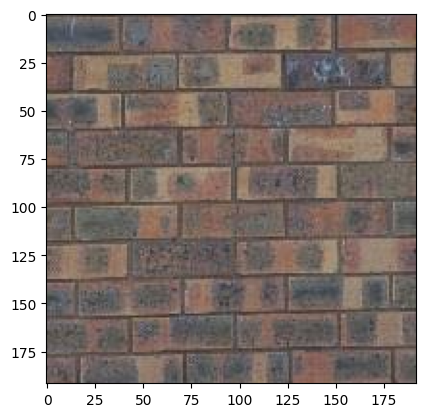

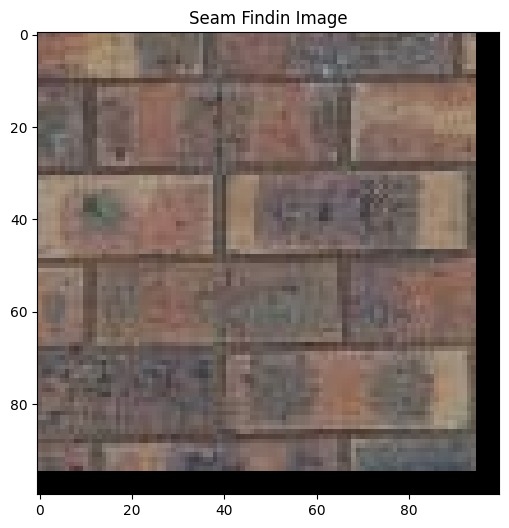

In [43]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 100  # change these parameters as needed
patch_size = 95
overlap = 11
tol = 3
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(6,6))
    plt.imshow(res)
    plt.title("Seam Findin Image")
    plt.show()

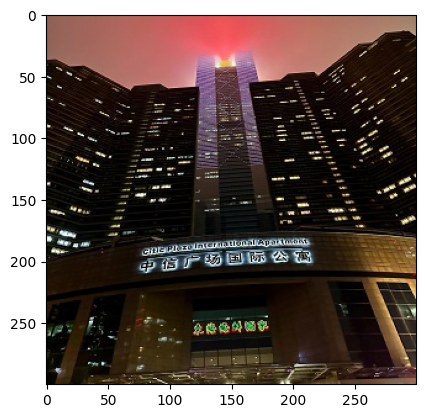

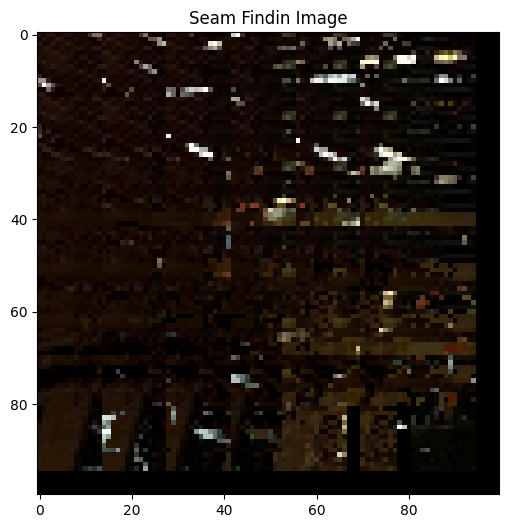

In [62]:
sample_img_fn = 'samples/quilt2.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 100  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 3
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(6,6))
    plt.imshow(res)
    plt.title("Seam Findin Image")
    plt.show()

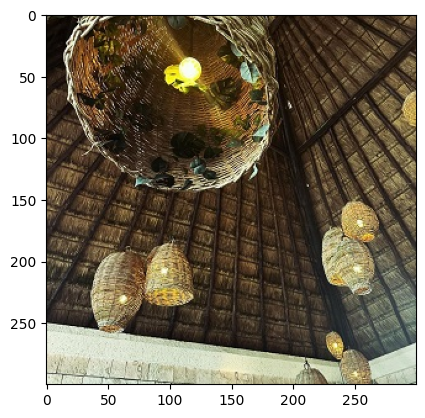

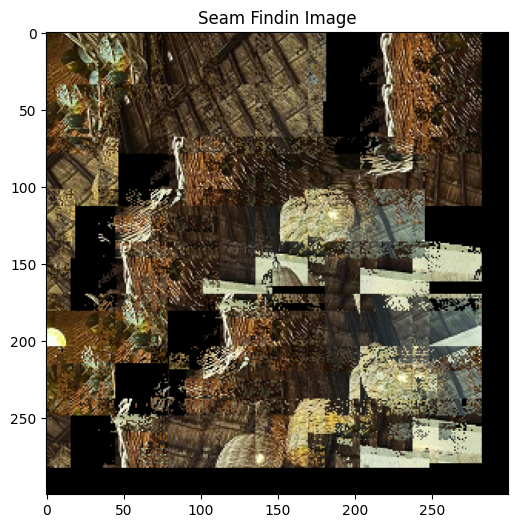

In [56]:
sample_img_fn = 'samples/quil3.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 45
overlap = 11
tol = 3
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(6,6))
    plt.imshow(res)
    plt.title("Seam Findin Image")
    plt.show()

### part IV: Texture Transfer (30 pts)

In [64]:
# helper ssd_patch
def ssd_patch2(image, template, mask, patch_size):
    ssd_cost = np.zeros(image.shape[:2], dtype='f')

    for ch in range(3):
        ssd_cost += ((mask * template[:, :, ch]) ** 2).sum() \
                    - 2 * cv2.filter2D(image[:, :, ch], ddepth=-1, kernel=mask * template[:, :, ch]) \
                    + cv2.filter2D(image[:, :, ch] ** 2, ddepth=-1, kernel=mask)

    top = ssd_cost.max()
    mid = patch_size // 2
    ssd_cost[:mid, :] = top
    ssd_cost[-mid:, :] = top
    ssd_cost[:, :mid] = top
    ssd_cost[:, -mid:] = top
    return ssd_cost

In [65]:
# helper choose_sample
def choose_sample2(ssd_cost, texture_im, patch_size, tol):

    idx = np.argsort(ssd_cost, axis=None)[:tol]
    x, y = np.unravel_index(np.random.choice(idx), ssd_cost.shape)
    mid = patch_size // 2
    patch = texture_im[x - mid:x + mid + 1, y - mid:y + mid + 1].copy()
    return patch


In [66]:
#helper merge
def merge(width, height, template, patch):
        mask = np.ones(patch.shape[:2], dtype='i')

        if width > 0:
            out_x, out_y = template[:overlap, :], patch[:overlap, :]
            out = np.sum((out_x - out_y) ** 2, axis=2)
            mask[:overlap, :] = np.logical_and(mask[:overlap, :], cut(out))

        if height > 0:
            out_x, out_y = template[:, :overlap], patch[:, :overlap]
            out = np.sum((out_x - out_y) ** 2, axis=2)
            mask[:, :overlap] = np.logical_and(mask[:, :overlap], cut(out.T).T)

        mask = np.expand_dims(mask, axis=2)
        out = mask * patch + (1 - mask) * template
        return out

In [67]:
def texture_transfer(texture_im, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """

    out_y, out_x = guidance_im.shape[:2]
    texture_im, guidance_im = texture_im.astype('f'), guidance_im.astype('f')
    out = np.zeros((out_y, out_x, 3), dtype='f')
    step = patch_size - overlap
    out_i, out_j = (out_y-patch_size)//step + 1, \
                   (out_x-patch_size)//step + 1
    # itr 
    for i in range(out_i):
        for j in range(out_j):
            first = np.zeros((patch_size, patch_size), dtype='f')
            if i > 0:
                first[:overlap, :] = 1.0
            if j > 0:
                first[:, :overlap] = 1.0

            second = np.ones((patch_size, patch_size), dtype='f')
            x, y = i*step, j*step
            temp1 = out[x:x+patch_size, y:y+patch_size].copy()
            temp2 = guidance_im[x:x+patch_size, y:y+patch_size].copy()

            # ssd_cost
            ssd_cost = alpha * ssd_patch2(texture_im, temp1, first,patch_size)\
                       + (1 - alpha) * ssd_patch2(texture_im, temp2, second,patch_size)
            # lowest
            patch = choose_sample2(ssd_cost, texture_im, patch_size, tol)

            # merge
            new_patch = merge(x, y, temp1, patch)
            out[x:x+patch_size, y:y+patch_size] = new_patch

    return out.astype('i')

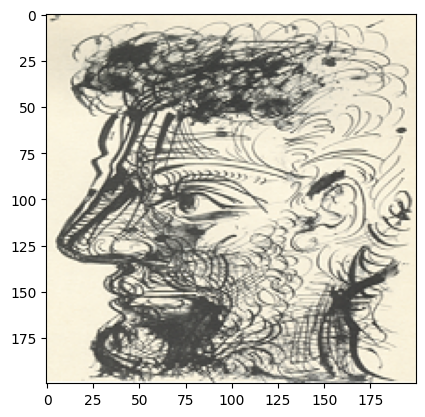

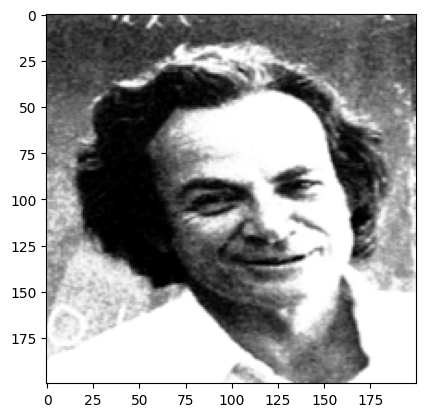

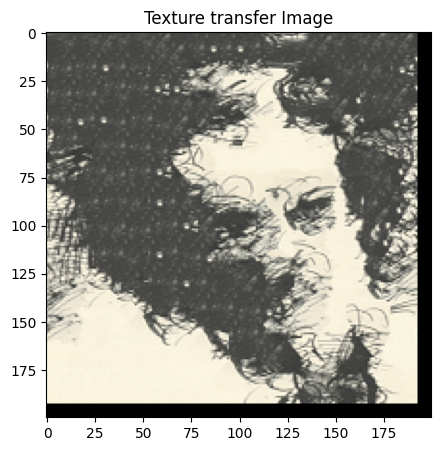

In [68]:
# load/process appropriate input texture and guidance images
text = 'samples/sketch.tiff'
guid = 'samples/feynman.tiff'

#texture_img = cv2.imread(text, cv2.IMREAD_GRAYSCALE) / 255.0
#texture_img = np.stack([texture_img] * 3, axis=-1)

texture_img = cv2.cvtColor(cv2.imread(text), cv2.COLOR_BGR2RGB)

guidance_img = cv2.cvtColor(cv2.imread(guid), cv2.COLOR_BGR2RGB)

#guidance_img = cv2.imread(guid, cv2.IMREAD_GRAYSCALE) / 255.0
#guidance_img = np.stack([guidance_img] * 3, axis=-1)

plt.imshow(texture_img)
plt.show()
plt.imshow(guidance_img)
plt.show()

patch_size = 25
overlap = 11
tol = 5
alpha = 0.3
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)
plt.figure(figsize=(5,5))
plt.imshow(res)
plt.title("Texture transfer Image")
plt.show()

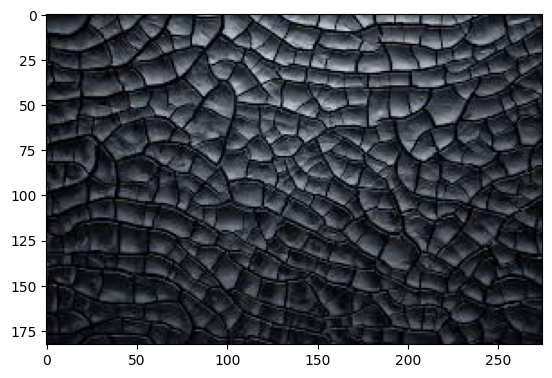

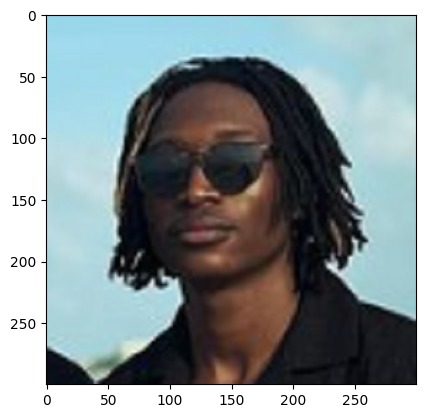

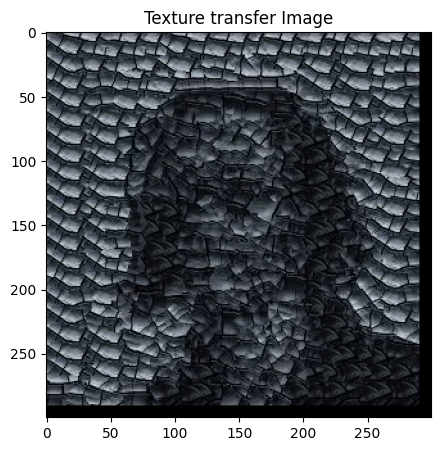

In [70]:
# load/process appropriate input texture and guidance images
text2 = 'samples/text4.jpeg'
guid2 = 'samples/guid4.jpg'



texture_img2 = cv2.cvtColor(cv2.imread(text2), cv2.COLOR_BGR2RGB)

guidance_img2 = cv2.cvtColor(cv2.imread(guid2), cv2.COLOR_BGR2RGB)


plt.imshow(texture_img2)
plt.show()
plt.imshow(guidance_img2)
plt.show()

patch_size2 = 25
overlap2 = 11
tol2 = 5
alpha2 = 0.3
res2 = texture_transfer(texture_img2, patch_size2, overlap2, tol2, guidance_img2, alpha2)
plt.figure(figsize=(5,5))
plt.imshow(res2)
plt.title("Texture transfer Image")
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).